In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint




**Updated how files are uploaded; all though Team Dropbox folder.**
- Must have a shortcut to the Team Dropbox folder in 'My Drive' in order to function properly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/My Drive/Team Dropbox/human+activity+recognition+using+smartphones/UCI HAR Dataset/train')

['y_train.txt', 'subject_train.txt', 'X_train.txt', 'Inertial Signals']

In [ ]:
import pandas as pd

# Load Excel
xl = pd.ExcelFile("/content/drive/My Drive/Team Dropbox/Final Featureset Algorithms/Final Features.xlsx")

sheet_name = [s for s in xl.sheet_names if "final" in s.lower()][0]

final_feats_df = pd.read_excel(xl, sheet_name=sheet_name)

final_features = (
    final_feats_df.iloc[:, 0]
    .dropna()
    .astype(str)
    .str.extract(r'(\d+)').astype(int)
    .drop_duplicates()
    .squeeze()
    .tolist()
)

print("Number of final features:", len(final_features))
print("Example indices:", final_features[:10])

Number of final features: 130
Example indices: [3, 4, 6, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Team Dropbox/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt', sep=r"\s+", header=None)

X_test = pd.read_csv('/content/drive/MyDrive/Team Dropbox/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt', sep=r"\s+", header=None)

y_train = pd.read_csv("/content/drive/MyDrive/Team Dropbox/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt", sep=r"\s+", header=None, names=["Activity"])
y_test = pd.read_csv("/content/drive/MyDrive/Team Dropbox/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt", sep=r"\s+", header=None, names=["Activity"])


print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes:
X_train: (7352, 561)
y_train: (7352, 1)
X_test: (2947, 561)
y_test: (2947, 1)


In [ ]:
X_train_final = X_train.iloc[:, final_features]
X_test_final  = X_test.iloc[:, final_features]

print("Filtered training shape:", X_train_final.shape)
print("Filtered testing shape:", X_test_final.shape)


Filtered training shape: (7352, 130)
Filtered testing shape: (2947, 130)


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_final, y_train["Activity"])

# Predict
rf_preds = rf.predict(X_test_final)

# Evaluate
print("Accuracy:", accuracy_score(y_test["Activity"], rf_preds))
print("\nClassification Report:")
print(classification_report(
    y_test["Activity"], rf_preds,
    labels=[1,2,3,4,5,6],
    target_names=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
))

Accuracy: 0.9151679674244995

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.99      0.94       496
  WALKING_UPSTAIRS       0.89      0.91      0.90       471
WALKING_DOWNSTAIRS       0.97      0.83      0.89       420
           SITTING       0.89      0.85      0.87       491
          STANDING       0.86      0.90      0.88       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.92      0.91      2947



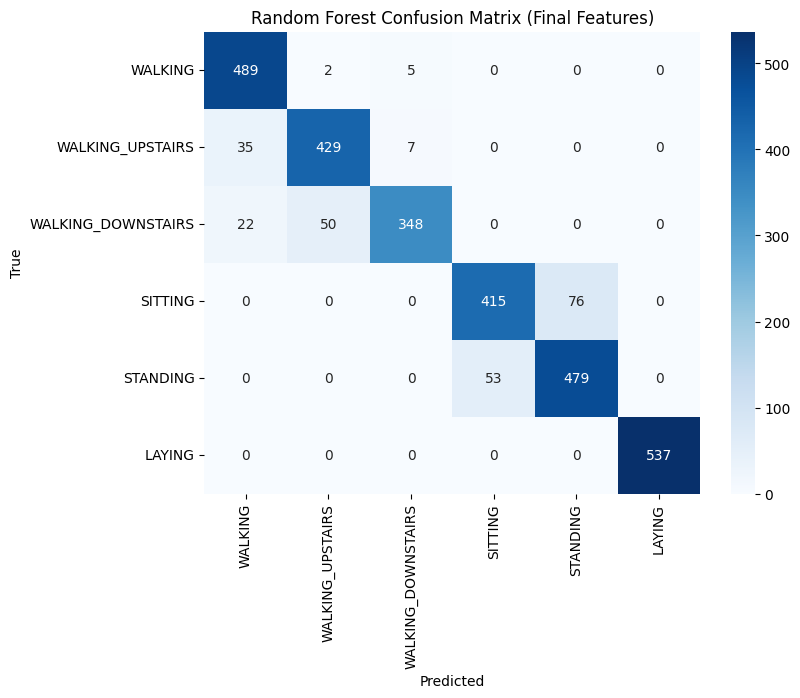

In [ ]:
cm = confusion_matrix(y_test["Activity"], rf_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"],
            yticklabels=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix (Final Features)")
plt.show()


In [ ]:
# Predict on training data
y_train_pred = rf.predict(X_train_final)
train_accuracy = accuracy_score(y_train['Activity'], y_train_pred)

# Predict on test data
y_test_pred = rf.predict(X_test_final)
test_accuracy = accuracy_score(y_test['Activity'], y_test_pred)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Train Accuracy: 1.000
Test Accuracy: 0.915


After Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train['Activity'])

results = pd.DataFrame(grid_search.cv_results_)
print(grid_search.best_params_)






Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Pivot table: rows=max_depth, columns=n_estimators, values=mean_test_score
pivot_table = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Random Forest Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()


ValueError: Index contains duplicate entries, cannot reshape

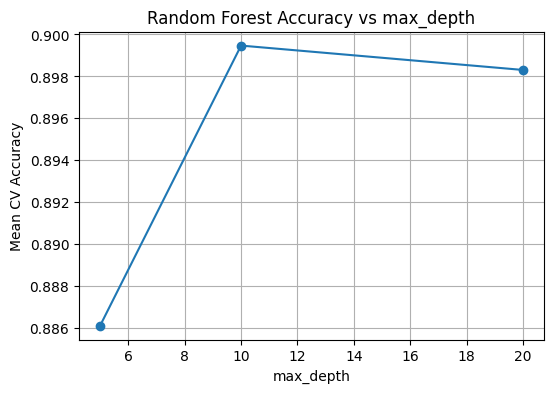

In [ ]:
# Example: accuracy vs max_depth (averaging over n_estimators)
mean_accuracy = results.groupby('param_max_depth')['mean_test_score'].mean()

plt.figure(figsize=(6,4))
plt.plot(mean_accuracy.index, mean_accuracy.values, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean CV Accuracy')
plt.title('Random Forest Accuracy vs max_depth')
plt.grid(True)
plt.show()

In [ ]:
#Weighing Classes using tuned hyperparams
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train_final, y_train["Activity"])

# Predict
rf_preds = rf.predict(X_test_final)

# Evaluate
print("Accuracy:", accuracy_score(y_test["Activity"], rf_preds))
print("\nClassification Report:")
print(classification_report(
    y_test["Activity"], rf_preds,
    labels=[1,2,3,4,5,6],
    target_names=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
))

Accuracy: 0.9104173736002714

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.88      0.98      0.93       496
  WALKING_UPSTAIRS       0.90      0.90      0.90       471
WALKING_DOWNSTAIRS       0.96      0.83      0.89       420
           SITTING       0.89      0.82      0.85       491
          STANDING       0.85      0.90      0.87       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947

